In [389]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [390]:
# read in excel with techniques and probabilities, sheet X removed latest 20%
excel_file_X = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\reduced_table_with_timestamps_and_props.xlsx", sheet_name="X")
excel_file_X = excel_file_X.set_index(["ID"])

# read in excel with correlations of techniques needed for fitness function
excel_corr = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\regression\corr_techniques.xlsx", sheet_name = "Sheet1")
excel_corr = excel_corr.drop('Unnamed: 0', 1)

# extract probabilities from excel and save as pd data frame
probs = pd.DataFrame(excel_file_X.iloc[0])
probs.iloc[0]
probs = probs.iloc[1:]

# read in excel with newest 20 percent of techniques for evaluation
excel_file_Y = pd.read_excel(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\reduced_table_with_timestamps_and_props.xlsx", sheet_name="y")
excel_file_Y = excel_file_Y.drop(excel_file_Y.tail(2).index, axis=0)
excel_file_Y.set_index('ID', inplace = True)
excel_file_Y_t = excel_file_Y.T
excel_file_Y_t = excel_file_Y_t.drop(['created'], axis = 0)

In [391]:
# read csv, convert creation dates to datetime format, sort column creation date
# csv_file = pd.read_csv(r"C:\Users\Jurek\Documents\Uni\Teamprojekt\attack-hypotheses-generation\matrix-with-timestemps-READY.csv",sep=";")
# csv_file_t = csv_file.T
# new_header = csv_file_t.iloc[0] #grab the first row for the header
# csv_file_t = csv_file_t[1:] #take the data less the header row
# csv_file_t.columns = new_header #set the header row as the df header
# csv_file_t['created'] = pd.to_datetime(csv_file_t['created'])
# csv_file_t
# csv_file_t.sort_values(by=['created'])

In [392]:
# function to create a starting population
def create_starting_population(individuals):
    # maybe later: add restriction for amount of ones in chromosome --> added
    # population = np.random.randint (2, size=(individuals, len(probs)))
    population = np.random.choice([0,1], size=(individuals, len(probs)), p= np.array([0.95,0.05])) # adjust % for number of ones
    return population

In [393]:
# example starting population
# print (create_starting_population(6))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [394]:
# function to calculate fitness of every individual in the current population
def calculate_fitness(individuals, probs):
    
    individuals = np.array(individuals) # individuals = 6x269
    probs = np.array (probs) # array with probabilities
    ones = np.ones(len(probs)) # number of ones 269x1
    occurrences = (individuals @ ones) # number of ones in individual 6x1
    corr = (individuals @ excel_corr) # array with population x correlations 6x269
#    print(corr)
#    print(excel_corr.shape)
#    print(corr.shape)
    
#     print (occurrences)
#     print (individuals.shape)
#     print (probs.shape)
    
    
    
    a = 100*(individuals @ probs)
    b = (np.subtract(occurrences,11)) # Intervall?
    c = (b**2)/2 # Wert 2 muss noch angepasst werden
    
#     target = 100*(individuals @ probs)
#     penalty = (np.subtract(occurrences,11))
#     for x in penalty:
#         if x > 0: # if occurence of 1s is higher than the average of 11
#             x = (x**2)/2
#         else: # if occurence of 1s is below the average of 11
#             x = x*20
        
    
#     print("")
#     print (a)
#     print("")
#     print(occurrences)
#     print("")
#     print (b)
#     print("")
#     print (c)
    
    
    fitness_scores = np.subtract(a.T, c)
    
 #   print (fitness_scores)
    
    return fitness_scores[0]

In [395]:
# test1 = create_starting_population(6)
# print('Startpopulation')
# print(test1)
# calculate_fitness(test1, probs)

In [396]:
#function to select individuals by using tournament selection
def select_individual_by_tournament(population, scores):
#     print (population)
#     print ("pop - scores")
#     print (scores)
    
    # get population size
    population_size = len(scores)
    

    # pick individuals for tournament
    fighter_1 = random.randint(0, population_size-1)
    fighter_2 = random.randint(0, population_size-1)
    
    # get fitness score for each individual
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
#     print("fighter_1_fitness")
#     print (scores[0])
    
    # identify undividual with highest fitness
    # fighter 1 will win if scores are equal
    if fighter_1_fitness >= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    #return the chromsome of the winner
    return population[winner, :]

In [397]:
# function to select individuals by using roulette wheel selection
# cannot be used yet, since it does not accept negative fitness values
# fitness value will represent the selection probability, which can't be negative
# idea1: normalise fitness values
# idea2: subtract the lowest (negative) value from all fitness values. The lowest fitness value is now zero.
def select_individual_by_roulette(population, k, scores): # list of individuals to select from, number of individuals to select, attribute to use as selection criteria
    s_inds = sorted(individuals, key = attrgetter(scores), reverse = True)
    sum_sc = sum(getattr(ind, scores).values[0] for ind in population)
    chosen = []
    for i in range(k):
        u = random.random()*sum_sc
        sum1 = 0
        for ind in s_inds:
            sum1 += getattr(ind, scores).values[0]
            if sum1 > u:
                chosen.append(ind)
                break
            
    return chosen

In [398]:
# function for executing one point crossover
# def breed_by_crossover_1point(parent_1, parent_2):
#     # get length of chromosome
#     chromosome_length = min(len(parent_1), len(parent_2))
    
#     # pick crossover point, avoding ends of chromsome
#     crossover_point = random.randint(1,chromosome_length-1)
    
#     # create children. np.hstack joins two arrays
#     child_1 = np.hstack((parent_1[0:crossover_point],
#                         parent_2[crossover_point:]))
    
#     child_2 = np.hstack((parent_2[0:crossover_point],
#                         parent_1[crossover_point:]))
    
#     # return children
#     return child_1, child_2

In [399]:
# function for executing one point crossover
def breed_by_crossover_1point(ind1, ind2):
    chromosome_length = min(len(ind1), len(ind2))
    crossover_point = random.randint(1, chromosome_length-1)
    
    ind1[crossover_point:], ind2[crossover_point:] = ind2[crossover_point:], ind1[crossover_point:]
    
    return ind1, ind2

In [400]:
# function for executin two point crossover
def breed_by_crossover_2point(ind1, ind2):
    chromosome_length = min(len(ind1), len(ind2))
    crossover_point1 = random.randint(1, chromosome_length)
    crossover_point2 = random.randint(1, chromosome_length-1)
    
    if crossover_point2 >= crossover_point1:
        crossover_point2 += 1
    else: # swapping the two crossover points
        crossover_point1, crossover_point2 = crossover_point2, crossover_point1
        
    ind1[crossover_point1: crossover_point2], ind2[crossover_point1: crossover_point2] \
        = ind2[crossover_point1: crossover_point2], ind1[crossover_point1: crossover_point2]
    
    return ind1, ind2

In [401]:
# function for executing uniform crossover
def breed_by_crossover_uniform(ind1, ind2, indpb):
    # parameter indpb is the indipendent probability for each bit to be exchanged
    # get length of chromosome
    chromosome_length = min(len(ind1), len(ind2))
    
    for i in range(chromosome_length):
        if random.random() < indpb: #add: lower probability that 0 --> 1 than the probability that 1 --> 0
             ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

In [402]:
# function to mutate population
def randomly_mutate_population(population, mutation_probability):
    
    # apply random mutation
        random_mutation_array = np.random.random(
            size=(population.shape))
        
        random_mutation_boolean = \
            random_mutation_array <= mutation_probability

        population[random_mutation_boolean] = \
        np.logical_not(population[random_mutation_boolean])
        
        # return mutation population
        return population

Starting best score: 3.6
End best score 12.3
[16. 15. 12. 12. 13. 12. 16. 12. 16. 15.]


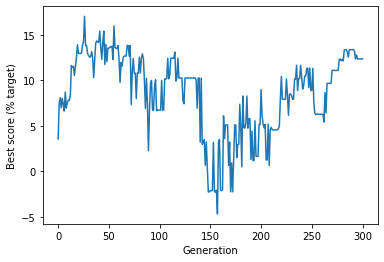

In [403]:
# main algorithm code
# set general parameters
chromosome_length = len(probs)
population_size = 10
maximum_generation = 300 # tested with 1000 generations, 250 to 300 generations seems reasonable for iterations
best_score_progress = [] # tracks progress

# create starting population
population = create_starting_population(population_size)

# print (population)
# display best score in starting population
scores = calculate_fitness(population, probs)
best_score = np.max(scores)
print ('Starting best score: %.1f' %best_score)

# add starting best score to progress tracker
best_score_progress.append(best_score)

# going through the generations of genetic algorithm
for generation in range(maximum_generation):
    # create an empty list for new population
    new_population = []
    
    # create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = select_individual_by_tournament(population, scores)
        parent_2 = select_individual_by_tournament(population, scores)
        #child_1, child_2 = breed_by_crossover_1point(parent_1, parent_2)
        #child_1, child_2 = breed_by_crossover_2point(parent_1, parent_2) # Results are not as promising as with the others
        child_1, child_2 = breed_by_crossover_uniform(parent_1, parent_2, 0.5)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # replace the old population with the new one
    population = np.array(new_population)
    
    # apply mutation
    mutation_rate = 0.002
    population = randomly_mutate_population(population, mutation_rate)

    # score best solution, and add to tracker
    scores = calculate_fitness(population, probs)
    best_score = np.max(scores)
    best_score_progress.append(best_score)
    
    # print(best_score)

# GA has completed required generation number
print ('End best score %.1f' %best_score)

ones = np.ones(len(probs)) # number of ones 269x1
occurrences = (population @ ones)
print (occurrences)

# plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()

In [404]:
for i in range(0,10):
    print (population[i])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 

In [405]:
# Print out information about best individuum
print('Best score target generation: %.1f' %best_score)
max_index_row = np.argmax(scores, axis=0)
print ('Position in Array:', max_index_row)
print("Number of Ones:", occurrences[max_index_row])
print("")
print("Respective Chromosome:", population[max_index_row] )
print("")

print("Techniques used:")
i = 0
for row in probs.index: 
    if population [max_index_row][i] == 1:
        print(row)
    i+=1
#excel_file_Y_t = excel_file_Y_t.set_index(['ID'])
#excel_file_Y_t = excel_file_Y_t.drop([100,101], axis = 1)

best_sw = np.tile(population[max_index_row],1) 
# excel_file_Y_t
# print(scores)

Best score target generation: 12.3
Position in Array: 2
Number of Ones: 12.0

Respective Chromosome: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]

Techniques used:
T1134.001
T1547.001
T1543
T1573.002
T1070.005
T1105
T1185
T1201
T1057
T1053.005
T1489
T1049


In [411]:
# class to combine scores, occurrences and population
class result:
    def __init__(self, score, occurences, population):
        self.score = score
        self.occurences = occurences
        self.population = population

# sort attribute scores in order to select best X individuums for evaluation
results = []
for i in range(0,len(scores)):
#    print(i)
    r1 = result(scores[i], occurrences[i], population[i])
    results.append(r1)
    
import operator
sorted_results = sorted(results, key=operator.attrgetter('score'))

In [412]:
# for i in sorted_results:
#     print(i.population)

In [422]:
# comparison between the 5 best predicted software and last 20% of test dataset
ones = np.ones(len(excel_file_Y_t))
for i in range(len(sorted_results)-5,len(sorted_results)):
    #best_sw = np.tile(sorted_results[i].population,1)
    best_sw = sorted_results[i].population
    print("---NEXT INDIVIDUUM---")
    print("Fitness score of individuum: ",sorted_results[i].score)
    print(best_sw)
    print("")
    for software in excel_file_Y_t.columns:
        sum_s = excel_file_Y_t[software] @ best_sw
        print("Sum divided by # of ones in predicted Software")
        print ((sum_s/sorted_results[i].occurences))
        print("Sum divided by # of ones in last 20% of software")
        print((sum_s/(excel_file_Y_t[software]@ ones)))
        print("")
        
# for i in range(len(sorted_results)-5,len(sorted_results)):
#     print(sorted_results[i].score)
# sorted_results[0].score

---NEXT INDIVIDUUM---
Fitness score of individuum:  10.987317989666511
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]

Sum divided by # of ones in predicted Software
0.15384615384615385
Sum divided by # of ones in last 20% of software
0.1

Sum divided by # of ones in predicted Software
0.07692307692307693
Sum divided by # of ones in last 20% of software
0.25

Sum divided by # of ones in predicted Software
0.07692307692307693
Sum divided by # of ones in last 20% of software
0.2

Sum divided by # 


Sum divided by # of ones in predicted Software
0.08333333333333333
Sum divided by # of ones in last 20% of software
0.2

Sum divided by # of ones in predicted Software
0.16666666666666666
Sum divided by # of ones in last 20% of software
0.1

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.08333333333333333
Sum divided by # of ones in last 20% of software
0.1111111111111111

Sum divided by # of ones in predicted Software
0.08333333333333333
Sum divided by # of ones in last 20% of software
0.125

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.13636363636363635

Sum divided by # of ones in predicted Software
0.16666666666666666
Sum divided by # of ones in last 20% of software
0.13333333333333333

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.23076923076923078

Sum divided 

0.13636363636363635

Sum divided by # of ones in predicted Software
0.16666666666666666
Sum divided by # of ones in last 20% of software
0.13333333333333333

Sum divided by # of ones in predicted Software
0.25
Sum divided by # of ones in last 20% of software
0.23076923076923078

Sum divided by # of ones in predicted Software
0.16666666666666666
Sum divided by # of ones in last 20% of software
0.2222222222222222

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.08333333333333333
Sum divided by # of ones in last 20% of software
0.047619047619047616

Sum divided by # of ones in predicted Software
0.0
Sum divided by # of ones in last 20% of software
0.0

Sum divided by # of ones in predicted Software
0.08333333333333333
Sum divided by # of ones in last 20% of software
0.05

Sum divided by # of ones in predicted Software
0.16666666666666666
Sum divided by # of ones in last 20% of softwar

In [409]:
# for obj in sorted_results:
#     print("Scores")
#     print(obj.score)
#     print("# of Ones")
#     print(obj.occurences)
#     print("Related Chromosome")
#     print(obj.population)
#     print("")
# print(obj.score)
# len(sorted_results)

In [410]:
# deprecated
# comparison between best predicted software and last 20% of test dataset
# techniques = excel_file_Y_t.index
# ones = np.ones(len(excel_file_Y_t))
# for software in excel_file_Y_t.columns:
#     sum_s = excel_file_Y_t[software] @ best_sw 
#     print("Sum divided by # of ones in predicted Software")
#     print ((sum_s/occurrences[max_index_row]))
#     print("Sum divided by # of ones in last 20% of software")
#     print((sum_s/(excel_file_Y_t[software]@ ones)))
#     print("")
#     for t in techniques:
#         if best_sw [index] ==1:
#         #counter += 1
#             print (excel_file_Y_t[software][t])
#        index += 1